# Fine-mapping workflow using summary statistics

This is a workflow that does summary statistics fine-mapping using SuSiE, DAP-G and CAVIAR.

This pipeline was devised by Gao Wang and implemented by Gao Wang with input from Yuxin Zou at The University of Chicago. It can be downloaded [from here](https://github.com/gaow/fine-mapping/tree/master/workflow). 
SuSiE is implemented in [`susieR`](https://github.com/stephenslab/susieR) (please use version 0.6.2+).

`susieR` is flexible in input format (R data matrices). Since we need to analyze the data with command executables such as DAP-G and CAVIAR we make input format compatible with these tools.

## Software preparation

Update SoS and sos-notebook

```
pip install -U sos sos-notebook
```

To run SuSiE, Install `susieR` and `dscrutils`
```
devtools::install_github("stephenslab/susieR")
devtools::install_github("stephenslab/dsc", subdir = "dscrutils", force = TRUE)
```

To run GAP-G and CAVIAR, make sure GSL exists

```
sudo apt-get install libgsl-dev
```

and make sure DAP-G and CAVIAR exists under `$PATH`.

To install a specified version of CAVIAR, eg for commit ID `743038a`:

```
curl -L https://github.com/fhormoz/caviar/tarball/743038a32ae66ea06ee599670cb7939fb80a923f -o caviar.tar.gz \
    && tar -zxvf caviar.tar.gz && cd fhormoz-caviar-*/CAVIAR-C++ && make
```

You should then see files `CAVIAR eCAVIAR mupCAVIAR setCAVIAR` under the current directory `fhormoz-caviar-*/CAVIAR-C++`. You can either move them to your system's `$PATH`, or just leave them there and use `-b` option in `sos run` call, see examples in workflow demo commands below.

Same for DAP-G,

```
curl -L https://github.com/xqwen/dap/tarball/ef11b263ae5e11b9e2e295757927877c03274095 -o dap.tar.gz \
    && tar -zxvf dap.tar.gz && cd xqwen-dap-*/dap_src && make
```

You should see file `dap-g` under `xqwen-dap-*/dap_src`.

## Input data

Input data relies on the output of the pipeline `summary_statistics_wrangler.ipynb` (an example input data-set for this pipeline can be found in that notebook). The input format is the same for SuSiE, DAP and CAVIAR.

## Output format

Output is still work in progress. 

Currently they are just R or Python data objects `*.rds` or `*.pkl` files and can be loaded via `dscrutils::read_dsc`. It contains the most comprehensive information and can be used to generate more succinct output files downstream. Additionally there will be a PDF file to visualize PIP and original $z$ scores.

In [1]:
%cd ~/GIT/github/fine-mapping

/scratch/midway2/gaow/GIT/github/fine-mapping

## The workflow

In [2]:
sos run workflow/summary_statistics_finemapping.ipynb -h

usage: sos run workflow/summary_statistics_finemapping.ipynb
               [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  susie_bhat
  susie_z
  dap
  caviar
  finemap

Global Workflow Options:
  --loci . (as path)
                        Loci file
  --ss-data-prefix . (as path)
                        summary statistics file prefix
  --annotation uniform
                        annotation "tag"
  --n 0 (as int)
                        sample size
  --var-y 0 (as int)
                        variance of phenotype. Set to zero for "unspecified"
  --job-size 80 (as int)
                        For cluster jobs, number of loci to analyze per job

Sections
  susie_bhat_1:         Run Su

In [1]:
[global]
# Loci file
parameter: loci = path()
# summary statistics file prefix
parameter: ss_data_prefix = path()
# annotation "tag"
parameter: annotation = "uniform"
# sample size
parameter: n = 0
# variance of phenotype. Set to zero for "unspecified"
parameter: var_y = 0
# For cluster jobs, number of loci to analyze per job
parameter: job_size = 80

fail_if(not loci.is_file(), msg = 'Please specify valid path for --loci')
fail_if(ss_data_prefix.is_file(), msg = '--ss-data-prefix should be a path not a file (usually file without extension, if using input from my data wrangling pipeline)')

ss_data_prefix = ss_data_prefix.absolute()
chunks = [x.strip().split() for x in open(f'{loci:a}').readlines() if not x.strip().startswith('#')]
chunks = [x[3] if len(x) == 4 else "%s_%s_%s" % (x[0], x[1], x[2]) for x in chunks]
data = [f'{ss_data_prefix}/{x}/{x}.summary_stats.gz' for x in chunks]

def fmtP(x):
    return str(x).replace(".", "p").replace(' ', '_').replace('"', "").replace("'", "").replace("-", '_')

def is_data_file_empty(f, min_row = 0):
    if f.stat().st_size == 0:
        return True
    import pandas
    try:
        x = pandas.read_csv(str(f), compression='gzip', nrows=min_row + 1, delim_whitespace = True)
    except pandas.errors.EmptyDataError:
        return True
    if x.shape[1] == 1:
        return True
    if x.shape[0] <= min_row:
        return True
    return False

### SuSiE $\hat{b}$ version

In [2]:
# Run SuSiE bhat version
[susie_bhat_1]
fail_if(n<=2, msg = 'Please specify valid sample size --n')
depends: R_library('data.table'), R_library('susieR')
# Set pve to 0.0 to estimate from data
parameter: susie_pve = 0.1
# use --pve-is-total to indicate the pve set above is for the entire loci
# and should be divided over number of variables
parameter: pve_is_total = False
# Whether or not to estimate residual variance
parameter: susie_est_residual = False
# Set maximum number of effect variables
parameter: L = 5
# Whether or not to keep fit from each iteration,
# for debug purpose.
parameter: track_fit = False
import os
#
suffix = f'SuSiE_B.L_{L}.prior_{fmtP(susie_pve)}.res_var_{str(susie_est_residual).lower()}'
var_y_str = f'var_y = {var_y},' if var_y > 0 else ''
#
input: data, group_by = 1
output: f'{_input:nn}.{annotation}.{suffix}.rds'
skip_if(is_data_file_empty(_input))

task: trunk_workers = 1, trunk_size = job_size, walltime = '10m', mem = '8G', cores = 1, tags = f'{step_name}_{_output:bn}'

prior_str = f'read.table(gzfile("{_input:nn}.{annotation}.gz"))[,2]' if os.path.isfile(f"{_input:nn}.{annotation}.gz") else 'NULL'
fail_if(annotation != 'uniform' and prior_str == 'NULL', msg = f"Cannot find annotation file for ``{annotation}``. Please use --annotation uniform if you do not want to apply any annotations")
R: expand = '${ }', stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'
    data = read.table(gzfile(${_input:ar}), head = F, stringsAsFactors = FALSE)
    prior = ${prior_str}
    r = as.matrix(data.table::fread("zcat ${_input:nn}.LD.gz"))
    if (ncol(data) == 3) {
      bhat = data[,2]
      shat = data[,3]
      p_values = 2 * pt(-abs(bhat / shat), df = ${n} - 2)
      z_scores = abs(qnorm(p_values/2)) * sign(bhat)      
    } else {
      bhat = data[,2]
      shat = rep(1, length(bhat))
      z_scores = data[,2]
    }
    library(susieR)
    L = min(${L}, length(z_scores))
    s = susie_bhat(bhat, shat, r, ${n}, ${var_y_str} r_tol = 5e-3, L = L, min_abs_corr = 0.1,
                  ${'estimate_prior_variance=TRUE' if susie_pve == 0 else 'scaled_prior_variance=' + str(susie_pve) + ('/length(bhat)' if pve_is_total else '')},
                  ${'estimate_residual_variance=TRUE' if susie_est_residual else 'estimate_residual_variance=FALSE'},
                  prior_weights=prior, track_fit=${"T" if track_fit else "F"})
    s$prior = prior
    s$z = z_scores
    s$var_names = data[,1]
    if (${susie_pve} == 0 && ${int(susie_est_residual)}) print(paste(c("Estimated PVE:", round(s$V/s$sigma2, 4)), collapse = ' '))
    if (${"T" if track_fit else "F"}) susie_plot_iteration(s, L, ${_input:nr})
    saveRDS(s, ${_output:r})

### SuSiE $z$ version

In [3]:
# Run SuSiE Z score version
[susie_z_1]
depends: R_library('data.table'), R_library('susieR')
# Set maximum number of effect variables
parameter: L = 5
# Whether or not to keep fit from each iteration,
# for debug purpose.
parameter: track_fit = False
import os
#
suffix = f'SuSiE_Z.L_{L}'
#
input: data, group_by = 1
output: f'{_input:nn}.{annotation}.{suffix}.rds'
skip_if(is_data_file_empty(_input))

task: trunk_workers = 1, trunk_size = job_size, walltime = '10m', mem = '8G', cores = 1, tags = f'{step_name}_{_output:bn}'

prior_str = f'read.table(gzfile("{_input:nn}.{annotation}.gz"))[,2]' if os.path.isfile(f"{_input:nn}.{annotation}.gz") else 'NULL'
fail_if(annotation != 'uniform' and prior_str == 'NULL', msg = f"Cannot find annotation file for ``{annotation}``. Please use --annotation uniform if you do not want to apply any annotations")
R: expand = '${ }', stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'
    data = read.table(gzfile(${_input:ar}), head = F, stringsAsFactors = FALSE)
    prior = ${prior_str}
    r = as.matrix(data.table::fread("zcat ${_input:nn}.LD.gz"))
    if (ncol(data) == 3) {
      bhat = data[,2]
      shat = data[,3]
      if (${n} > 0) {
          p_values = 2 * pt(-abs(bhat / shat), df = ${n} - 2)
          z_scores = abs(qnorm(p_values/2)) * sign(bhat)
      } else {
          z_scores = data[,2] / data[,3]
      }
    } else {
      z_scores = data[,2]
    }
    library(susieR)
    L = min(${L}, length(z_scores))
    s = susie_rss(z_scores, r, r_tol = 5e-3, L = L, min_abs_corr = 0.1,
                  prior_weights=prior, track_fit=${"T" if track_fit else "F"})
    s$prior = prior
    s$z = z_scores
    s$var_names = data[,1]
    if (${"T" if track_fit else "F"}) susie_plot_iteration(s, L, ${_input:nr})
    saveRDS(s, ${_output:r})

### DAP-G

In [4]:
# Run DAP-G
[dap_1]
fail_if(n<=2, msg = 'Please specif valid sample size --n')
# Extra arguments to pass to DAP
parameter: args = ''
import os
suffix = f'DAP{"."+fmtP(args) if len(args) else ""}'
#
depends: executable('dap-g'), Py_Module('pandas'), Py_Module('numpy')
input: data, group_by = 1
output: f'{_input:nn}.{annotation}.{suffix}.pkl'
skip_if(is_data_file_empty(_input))

task: trunk_workers = 1, trunk_size = job_size, walltime = '10m', mem = '8G', cores = 1, tags = f'{step_name}_{_output:bn}'
prior_file = f"{_input:ann}.{annotation}.gz" if os.path.isfile(f"{_input:ann}.{annotation}.gz") else None
fail_if(annotation != 'uniform' and prior_file is None, msg = f"Cannot find annotation file for ``{annotation}``. Please use --annotation uniform if you do not want to apply any annotations")

python: expand = '${ }', stderr = f'{_output:n}.stderr', workdir = f'{_output:ad}'
    import sys
    import pandas as pd
    import numpy as np
    import os, subprocess
    import pickle
    def run_dap_ss(prefix, data_file, ld_file, n, varY, prior_file = None, args = ''):
        cmd = ['dap-g', '-d_est', f'<(zcat {data_file})', '-d_ld', f'<(zcat {ld_file})', '-d_n', n, '-d_syy', varY, '-o', f'{prefix}.result', '-l', f'{prefix}.stderr', '--all', args]
        if prior_file is not None:
            cmd.extend(['-p', f'<(zcat {prior_file})'])
        cmd = ' '.join(map(str,cmd))
        sys.stderr.write(cmd + '\n')
        subprocess.Popen(cmd, shell=True, executable='/bin/bash')

    def extract_dap_output(prefix):
        out = [x.strip().split() for x in open(f'{prefix}.result').readlines()]
        pips = []
        clusters = []
        still_pip = True
        for line in out:
            if len(line) == 0:
                continue
            if len(line) > 2 and line[2] == 'cluster_pip':
                still_pip = False
                continue
            if still_pip and (not line[0].startswith('((')):
                continue
            if still_pip:
                pips.append([line[1], float(line[2]), float(line[3]), int(line[4])])
            else:
                clusters.append([len(clusters) + 1, float(line[2]), float(line[3])])
        pips = pd.DataFrame(pips, columns = ['snp', 'snp_prob', 'snp_log10bf', 'cluster'])
        clusters = pd.DataFrame(clusters, columns = ['cluster', 'cluster_prob', 'cluster_avg_r2'])
        clusters = pd.merge(clusters, pips.groupby(['cluster'])['snp'].apply(','.join).reset_index(), on = 'cluster')
        return {'snp': pips, 'set': clusters}


    prior_file = None if ${prior_file is None} else "${prior_file}"
    run_dap_ss(${_output:bnr}, ${_input:ar}, "${_input:nn}.LD.gz", ${n}, ${1 if var_y == 0 else var_y}, prior_file, ${args})
    res = extract_dap_output(${_output:anr})
    res['var_names'] = np.loadtxt(${_input:ar}, dtype = str, usecols=0)
    ss = np.loadtxt(${_input:ar}, dtype = str)
    if ss.shape[1] == 3:
        res['z'] = ss[:,1].astype(float)/ss[:,2].astype(float)
    else:
        res['z'] = ss[:,1].astype(float)
    if prior_file is not None:
        res['prior'] = np.loadtxt(prior_file, dtype = float, usecols=1)
    pickle.dump(res, open(${_output:ar}, 'wb'))

### CAVIAR

In [ ]:
# Run CAVIAR
[caviar_1]
depends: executable('CAVIAR'), R_library('dplyr>=0.7.7'), R_library('readr'), R_library('magrittr'), R_library('dscrutils') # can be installed via `devtools::install_github("stephenslab/dsc",subdir = "dscrutils", force = TRUE)`
# Extra arguments to pass to CAVIAR
parameter: args = ''
suffix = f'CAVIAR{"."+fmtP(args) if len(args) else ""}'
#
input: data, group_by = 1
output: f'{_input:nn}.{suffix}.rds'
skip_if(is_data_file_empty(_input))

task: trunk_workers = 1, trunk_size = job_size, walltime = '15m', mem = '8G', cores = 1, tags = f'{step_name}_{_output:bn}'

R: expand = '${ }', stderr = f'{_output:n}.log', stdout = f'{_output:n}.log'
    library(dplyr)
    library(readr)
    library(magrittr)

    #' CAVIAR I/O
    prefix = ${_input:nnr}
    cfg = list( prefix=paste0(prefix,".CAVIAR"),
                z=paste0(prefix,".CAVIAR.z"),
                ld=paste0(prefix,".LD.txt"),
                ld_gz=paste0(prefix,".LD.gz"),
                set=paste0(prefix,".CAVIAR_set"),
                post=paste0(prefix,".CAVIAR_post"),
                log=paste0(prefix,".CAVIAR.log"))
    data = read.table(gzfile(${_input:ar}), head = F, stringsAsFactors = FALSE)
    if (ncol(data) == 3) {
        if (${n} > 0) {
          p_values = 2 * pt(-abs(data[,2] / data[,3]), df = ${n} - 2)
          z_scores = abs(qnorm(p_values/2)) * sign(data[,2])
        } else {
          z_scores = data[,2] / data[,3]
        }
        data = cbind(data[,1], z_scores)
        write.table(data,cfg$z,quote=F,col.names=F,row.names=F)
    } else {
      z_scores = data[,2]
      system("ln -s ${_input} ${_input:nnr}.CAVIAR.z")
    }

    #' Run CAVIAR
    #' https://github.com/fhormoz/caviar

    run_caviar <- function(cfg, args = "")
    {
      dscrutils::run_cmd(paste("zcat", cfg$ld_gz, ">", cfg$ld), ferr = FALSE)
      cmd = paste("CAVIAR", "-z", cfg$z, "-l", cfg$ld, "-o", cfg$prefix, args)
      dscrutils::run_cmd(cmd)
      unlink(cfg$ld, force=TRUE)
      unlink(cfg$z, force=TRUE)
      if(!all(file.exists(cfg$post, cfg$set, cfg$log))) {
          stop("Cannot find one of the post, set, and log files")
      }

      log <- readLines(cfg$log)

      # read output tables
      snp <- read.delim(cfg$post)  
      stopifnot(ncol(snp) == 3)
      names(snp) <- c("snp", "snp_prob_set", "snp_prob")
      snp$snp <- as.character(snp$snp)
      snp <- rank_snp(snp)

      # `set` of snps
      set <- readLines(cfg$set)
      set_ordered <- left_join(data_frame(snp = set), snp, by = "snp") %>% 
        arrange(rank) %$% snp
      return(list(snp=snp, set=set_ordered))
    }

    rank_snp <- function(snp) {
      snp <- arrange(snp, -snp_prob) %>%
        mutate(
            rank = seq(1, n()),
            snp_prob_cumsum = cumsum(snp_prob) / sum(snp_prob)) %>%
        select(rank, snp, snp_prob, snp_prob_cumsum, snp_prob_set)
      return(snp)    
    }

    res = run_caviar(cfg, ${args})
    res$z = z_scores
    res$var_names = data[,1]
    saveRDS(res, ${_output:ar})

### FINEMAP

In [ ]:
# Run FINEMAP
[finemap_1]
depends: executable('finemap'), R_library('dplyr>=0.7.7'), R_library('readr'), R_library('magrittr'), R_library('dscrutils') # can be installed via `devtools::install_github("stephenslab/dsc",subdir = "dscrutils", force = TRUE)`
# K parameter
parameter: k = 'NULL'
# Extra arguments to pass to FINEMAP
# eg, `--args "'--n-causal-max 3'"`
parameter: args = ''
suffix = f'FINEMAP{"."+fmtP(args) if len(args) else ""}'
fail_if(n < 2, msg = 'Sample size is invalid. Please set it properly via --n.')
#
input: data, group_by = 1
output: f'{_input:nn}.{suffix}.rds'
skip_if(is_data_file_empty(_input, min_row = 1))

task: trunk_workers = 1, trunk_size = job_size, walltime = '15m', mem = '8G', cores = 1, tags = f'{step_name}_{_output:bn}'

R: expand = '${ }', stderr = f'{_output:n}.log', stdout = f'{_output:n}.log'
    library(dplyr)
    library(readr)
    library(magrittr)

    #' FINEMAP I/O
    prefix = ${_input:nnr}
    cfg = list( prefix=paste0(prefix,".FINEMAP"),
                z=paste0(prefix,".FINEMAP.z"),
                ld=paste0(prefix,".LD.ld"),
                ld_gz=paste0(prefix,".LD.gz"),
                config=paste0(prefix,".FINEMAP.config"),
                k=paste0(prefix,".FINEMAP.k"),
                snp=paste0(prefix,".FINEMAP.snp"),
                meta=paste0(prefix,".FINEMAP.master"),
                log=paste0(prefix,".FINEMAP.log"))
    data = read.table(gzfile(${_input:ar}), head = F, stringsAsFactors = FALSE)
    if (ncol(data) == 3) {
        if (${n} > 0) {
          p_values = 2 * pt(-abs(data[,2] / data[,3]), df = ${n} - 2)
          z_scores = abs(qnorm(p_values/2)) * sign(data[,2])
        } else {
          z_scores = data[,2] / data[,3]
        }
        data = cbind(data[,1], z_scores)
        write.table(data,cfg$z,quote=F,col.names=F,row.names=F)
    } else {
      z_scores = data[,2]
      system("ln -s ${_input} ${_input:nnr}.FINEMAP.z")
    }
    if (!is.null(${k})) {
      write.table(t(${k}),cfg$k,quote=F,col.names=F,row.names=F)
      write("z;ld;snp;config;k;log;n-ind",file=cfg$meta)
      write(paste(cfg$z, cfg$ld, cfg$snp, cfg$config, cfg$k, cfg$log, ${n}, sep=";"),
        file=cfg$meta,append=TRUE)
    } else {
      write("z;ld;snp;config;log;n-ind",file=cfg$meta)
      write(paste(cfg$z, cfg$ld, cfg$snp, cfg$config, cfg$log, ${n}, sep=";"),
            file=cfg$meta,append=TRUE)
    }

    #' Run FINEMAP 1.1

    run_finemap <- function(cfg, args = "")
    {
      dscrutils::run_cmd(paste("zcat", cfg$ld_gz, ">", cfg$ld), ferr = FALSE)
      cmd = paste("finemap --sss --log", "--in-files", cfg$meta, args)
      dscrutils::run_cmd(cmd)
      unlink(cfg$ld, force=TRUE)
      unlink(cfg$z, force=TRUE)
      if(!all(file.exists(cfg$post, cfg$set, cfg$log))) {
          stop("Cannot find one of the post, set, and log files")
      }

      log <- readLines(cfg$log)

      # read output tables
      snp = read.table(cfg$snp,header=TRUE,sep=" ")
      snp$snp = as.character(snp$snp)

      snp = rank_snp(snp)
      config = read.table(cfg$config,header=TRUE,sep=" ")

      # extract number of causal
      ncausal = finemap_extract_ncausal(cfg$log)
      return(list(snp=snp, set=config, ncausal=ncausal))
    }

    rank_snp <- function(snp) {
      snp <- arrange(snp, -snp_prob) %>%
        mutate(
            rank = seq(1, n()),
            snp_prob_cumsum = cumsum(snp_prob) / sum(snp_prob)) %>%
        select(rank, snp, snp_prob, snp_prob_cumsum, snp_log10bf)
      return(snp)    
    }
  
    finemap_extract_ncausal <- function(logfile)
    {
      lines <- grep("->", readLines(logfile), value = TRUE)
      lines <- gsub("\\(|\\)|>", "", lines)
      splits <- strsplit(lines, "\\s+")
      tab <- data.frame(
        ncausal_num = sapply(splits, function(x) as.integer(x[2])),
        ncausal_prob = sapply(splits, function(x) as.double(x[4])))
      tab <- mutate(tab, type = ifelse(duplicated(ncausal_num), "post", "prior"))
      return(tab)
    }

    res = run_finemap(cfg, ${args})
    res$z = z_scores
    res$var_names = data[,1]
    saveRDS(res, ${_output:ar})

### Make diagnostic plot

In [5]:
# Summarize Fine-mapping results
[*_2 (plot PIP)]
depends: R_library('dscrutils') # can be installed via `devtools::install_github("stephenslab/dsc",subdir = "dscrutils", force = TRUE)`
output: f'{_input:n}.pdf'

task: trunk_workers = 1, trunk_size = job_size * 3, walltime = '2m', mem = '2G', cores = 1, tags = f'{step_name}_{_output:bn}'

R: expand = '${ }', stderr = f'{_output:n}.log', stdout = f'{_output:n}.stdout'
    s = dscrutils::read_dsc(${_input:r})
    # print something to log
    write(format(Sys.time(), "%a %b %d %X %Y"), stderr())
    library(susieR)
    is_susie = !is.null(s$elbo)
    if (is_susie) {
        write(paste('SuSiE objective:', susie_get_objective(s), "at L =", nrow(s$alpha)), stderr())
    } else {
        snp = s$snp
        snp = snp[match(s$var_names, snp$snp),]
        s$pip = snp$snp_prob
        class(s) = 'susie'
    }
    # make some plots
    pdf(${_output:r}, 8,9,pointsize=16)
    par(mar=c(2,4,0,0), omi=c(0,0,0,0), oma=c(0,0,0,0),mfrow=c(2,1))
    susie_plot(s,y='PIP',add_legend=T)
    susie_plot(s,y='z')
    dev.off()
    ordering = order(s$pip, decreasing=T)
    if (is.null(s$prior)) s$prior = rep(1/length(ordering),length(ordering))
    for (i in 1:5) {
        write(paste0("#", i, " pip-ranked SNP ", s$var_names[ordering[i]], " has z-score ", 
              round(s$z[ordering[i]],2), " pip ", round(s$pip[ordering[i]],4), " and prior ", round(s$prior[ordering[i]],4)), stderr())
    }
    ordering = order(abs(s$z), decreasing=T)
    for (i in 1:5) {
        write(paste0("#", i, " z-ranked SNP ", s$var_names[ordering[i]], " has z-score ", 
              round(s$z[ordering[i]],2), " pip ", round(s$pip[ordering[i]],4), " and prior ", round(s$prior[ordering[i]],4)), stderr())
    }

## Example usage

Commands below run the pipeline on a local computer. 

**For UChicago midway users**: to run these pipelines on RCC cluster, please take a look at `midway2.yml` file (found in this repository), modify it as you see fit, and replace `-q none -j 8` with: 

```
-c workflow/midway2.yml -q midway2 -J 40
```

### SuSiE $\hat{b}$

GWAS example run (with annotations):

In [5]:
sos run workflow/summary_statistics_finemapping.ipynb susie_bhat \
        --loci /home/gaow/tmp/19-Dec-2018/SCZ/chunks.list \
        --ss-data-prefix /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics \
        --annotation atac-seq \
        --n 79845 \
        --susie-pve 0.005 --L 5 \
        -q none -j 8

INFO: Running susie_bhat_1: Run SuSiE bhat version
INFO: susie_bhat_1 (index=0) is ignored due to saved signature
INFO: output:   /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_B.L_5.prior_0p005.res_var_true.rds
INFO: Running susie_bhat_2: Summarize Fine-mapping results
INFO: susie_bhat_2 (index=0) is ignored due to saved signature
INFO: output:   /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_B.L_5.prior_0p005.res_var_true.pdf
INFO: Workflow susie_bhat (ID=897b7f9c97b1a5d0) is ignored with 2 ignored steps.


%preview /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_B.L_5.prior_0p005.res_var_true.pdf

> /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_B.L_5.prior_0p005.res_var_true.pdf (7.6 KiB):

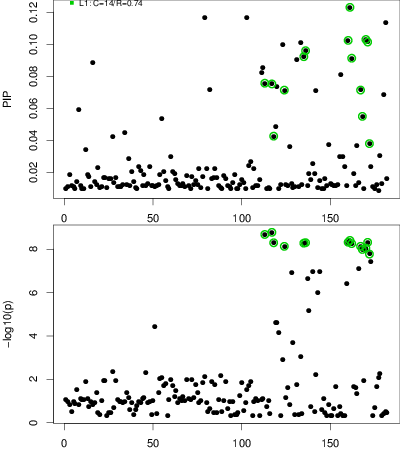

In [6]:
%preview /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_B.L_5.prior_0p005.res_var_true.pdf -s png --dpi 50

In [7]:
%preview /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_B.L_5.prior_0p005.res_var_true.log

%preview /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_B.L_5.prior_0p005.res_var_true.log

> /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_B.L_5.prior_0p005.res_var_true.log (837 B):

12 lines (5 displayed, see --limit)

Fri Dec 21 03:27:56 PM 2018
SuSiE objective: -113313.785692437 at L = 5
#1 pip-ranked SNP 9:84789089:T:C has z-score -5.77 pip 0.123 and prior 1e-04
#2 pip-ranked SNP 9:84700694:T:C has z-score -2.42 pip 0.1168 and prior 1e-04
#3 pip-ranked SNP 9:84725047:T:C has z-score -1.9 pip 0.1166 and prior 1e-04

eQTL example run (without annotations):

In [8]:
sos run workflow/summary_statistics_finemapping.ipynb susie_bhat \
        --loci /home/gaow/tmp/19-Dec-2018/metasoft/one_loci.txt \
        --ss-data-prefix /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats \
        --n 800 \
        --susie-pve 0.1 --L 5 \
        -q none -j 8

INFO: Running susie_bhat_1: Run SuSiE bhat version
INFO: output:   /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.uniform.SuSiE_B.L_5.prior_0p1.res_var_false.rds
INFO: Running susie_bhat_2: Summarize Fine-mapping results
null device 
          1 
INFO: output:   /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.uniform.SuSiE_B.L_5.prior_0p1.res_var_false.pdf
INFO: Workflow susie_bhat (ID=10c68937a3df62e9) is executed successfully with 2 completed steps.


%preview /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.uniform.SuSiE_B.L_5.prior_0p1.res_var_false.pdf

> /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.uniform.SuSiE_B.L_5.prior_0p1.res_var_false.pdf (4.8 KiB):

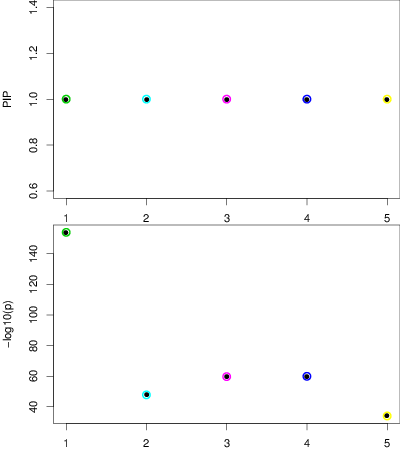

In [10]:
%preview /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.uniform.SuSiE_B.L_5.prior_0p1.res_var_false.pdf -s png --dpi 50

### SuSiE $z$

GWAS example run (with annotations):

In [11]:
sos run workflow/summary_statistics_finemapping.ipynb susie_z \
        --loci /home/gaow/tmp/19-Dec-2018/SCZ/chunks.list \
        --ss-data-prefix /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics \
        --annotation atac-seq \
        --L 5 \
        -q none -j 8

INFO: Running susie_z_1: Run SuSiE Z score version
INFO: output:   /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_Z.L_5.rds
INFO: Running susie_z_2: Summarize Fine-mapping results
null device 
          1 
INFO: output:   /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_Z.L_5.pdf
INFO: Workflow susie_z (ID=faeee78a5b518cd1) is executed successfully with 2 completed steps.


%preview /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_Z.L_5.pdf

> /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_Z.L_5.pdf (7.2 KiB):

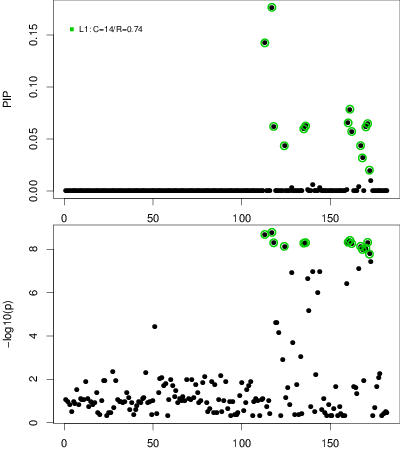

In [12]:
%preview /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.SuSiE_Z.L_5.pdf -s png --dpi 50

### DAP

GWAS example run (with annotations):

In [13]:
DAP_EXE_PATH=~/GIT/github/mvarbvs/dsc/modules/linux
sos run workflow/summary_statistics_finemapping.ipynb dap \
        --loci /home/gaow/tmp/19-Dec-2018/SCZ/chunks.list \
        --ss-data-prefix /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics \
        --annotation atac-seq \
        --n 79845 \
        -b $DAP_EXE_PATH \
        -q none -j 8

INFO: Running dap_1: Run DAP-G
INFO: output:   /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.DAP.pkl
INFO: Running dap_2: Summarize Fine-mapping results
null device 
          1 
INFO: output:   /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.DAP.pdf
INFO: Workflow dap (ID=c895e1125141fae4) is executed successfully with 2 completed steps.


%preview /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.DAP.pdf

> /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.DAP.pdf (7.0 KiB):

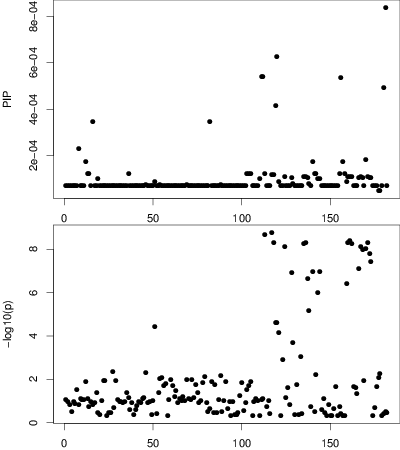

In [14]:
%preview /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.atac-seq.DAP.pdf -s png --dpi 50

### CAVIAR

GWAS example run:

In [15]:
CAVIAR_EXE_PATH=~/GIT/github/mvarbvs/dsc/modules/linux
sos run workflow/summary_statistics_finemapping.ipynb caviar \
        --loci /home/gaow/tmp/19-Dec-2018/SCZ/chunks.list \
        --ss-data-prefix /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics \
        -b $CAVIAR_EXE_PATH --args "'-c 2'" \
        -q none -j 8

INFO: Running caviar_1: Run CAVIAR
INFO: output:   /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.CAVIAR._c_2.rds
INFO: Running plot PIP: Summarize Fine-mapping results
null device 
          1 
INFO: output:   /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.CAVIAR._c_2.pdf
INFO: Workflow caviar (ID=23c609e929d3e8b1) is executed successfully with 2 completed steps.


%preview /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.CAVIAR._c_2.pdf

> /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.CAVIAR._c_2.pdf (7.1 KiB):

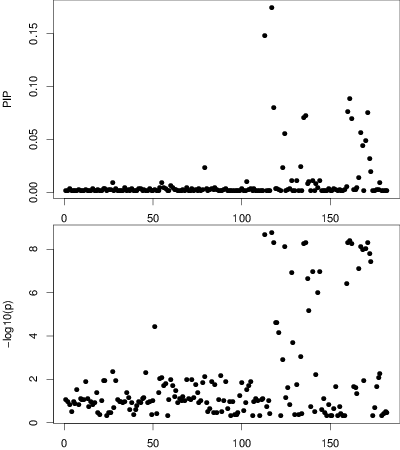

In [17]:
%preview /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.CAVIAR._c_2.pdf -s png --dpi 50

eQTL example run:

In [18]:
CAVIAR_EXE_PATH=~/GIT/github/mvarbvs/dsc/modules/linux
sos run workflow/summary_statistics_finemapping.ipynb caviar \
        --loci /home/gaow/tmp/19-Dec-2018/metasoft/one_loci.txt \
        --ss-data-prefix /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats \
        -b $CAVIAR_EXE_PATH --args "'-c 2'" \
        -q none -j 8

INFO: Running caviar_1: Run CAVIAR
INFO: output:   /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.CAVIAR._c_2.rds
INFO: Running plot PIP: Summarize Fine-mapping results
null device 
          1 
INFO: output:   /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.CAVIAR._c_2.pdf
INFO: Workflow caviar (ID=157b4cf09027e3f5) is executed successfully with 2 completed steps.


%preview /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.CAVIAR._c_2.pdf

> /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.CAVIAR._c_2.pdf (4.7 KiB):

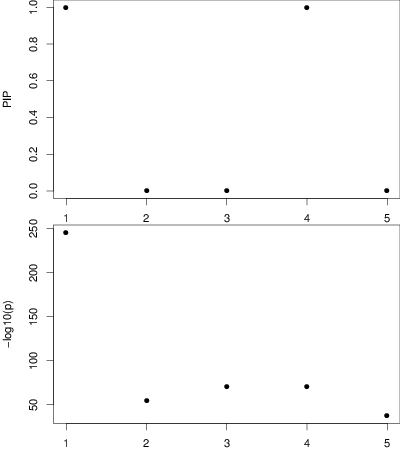

In [19]:
%preview /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.CAVIAR._c_2.pdf -s png --dpi 50

### FINEMAP

GWAS example run:

In [ ]:
FINEMAP_EXE_PATH=~/GIT/github/mvarbvs/dsc/modules/linux
sos run workflow/summary_statistics_finemapping.ipynb finemap \
        --loci /home/gaow/tmp/19-Dec-2018/SCZ/chunks.list \
        --ss-data-prefix /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics \
        -b $FINEMAP_EXE_PATH --n 500 \
        -q none -j 8

%preview /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.FINEMAP.pdf

> /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.FINEMAP.pdf (7.0 KiB):

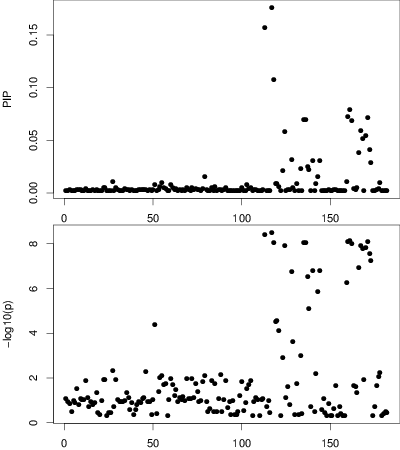

In [1]:
%preview /home/gaow/tmp/19-Dec-2018/SCZ/Summary_statistics/chr9_84630941_84813641/chr9_84630941_84813641.FINEMAP.pdf -s png --dpi 50

eQTL example run:

In [ ]:
FINEMAP_EXE_PATH=~/GIT/github/mvarbvs/dsc/modules/linux
sos run workflow/summary_statistics_finemapping.ipynb finemap \
        --loci /home/gaow/tmp/19-Dec-2018/metasoft/one_loci.txt \
        --ss-data-prefix /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats \
        -b $FINEMAP_EXE_PATH --n 500 \
        -q none -j 8

%preview /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.FINEMAP.pdf

> /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.FINEMAP.pdf (4.6 KiB):

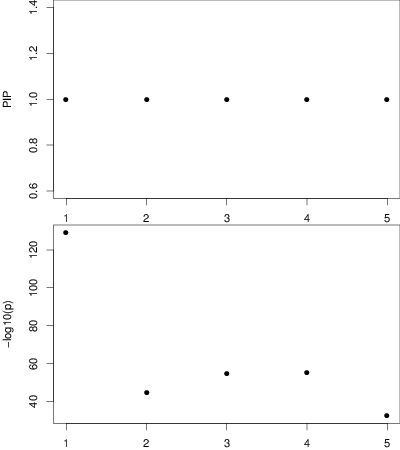

>>> /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.FINEMAP.pdf:

bash: /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.FINEMAP.pdf: Permission denied


In [2]:
%preview /home/gaow/tmp/19-Dec-2018/metasoft/gtex_metasoft_summary_stats/ENSG00000181404.15/ENSG00000181404.15.FINEMAP.pdf -s png --dpi 50